# **Dataset description**
https://drive.google.com/file/d/1v6aLMBb4w8QkIciqy34Sh_hOFeWQWm9j/view?usp=sharing

This dataset contains knee X-ray data for both knee joint detection and knee KL grading. The Grade descriptions are as follows:
*   **Grade 0**: Healthy knee image.
*   **Grade 1** (Doubtful): Doubtful joint narrowing with possible osteophytic lipping
*   **Grade 2** (Minimal): Definite presence of osteophytes and possible joint space narrowing
*   **Grade 3** (Moderate): Multiple osteophytes, definite joint space narrowing, with mild sclerosis.
*   **Grade 4** (Severe): Large osteophytes, significant joint narrowing, and severe sclerosis.


Acknowledgements:

Chen, Pingjun (2018), “Knee Osteoarthritis Severity Grading Dataset”, Mendeley Data, V1, doi: 10.17632/56rmx5bjcr.1
The dataset is organized from OAI.

In [1]:
#mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#!gdown https://drive.google.com/file/d/1owBxymTqB6esIKRn2uGZoL8kpY1U4X_i/view?usp=sharing

In [3]:
!unzip /content/gdrive/MyDrive/kneeXray_dataset.zip -d /content/gdrive/MyDrive/kneeXray_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9686908R.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9687273L.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9689906R.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9690910L.png  
 extracting: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9690910R.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9691359L.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9691359R.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9692163L.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9692604L.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9692604R.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9692923R.png  
  inflating: /content/gdrive/MyDrive/kneeXray_dataset/train/0/9693364R.png  
  inflating: /content/gdr

# Training

In [4]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

## Structure of our data folder

For this exercise, we’ll keep the following folder structure:

<div> <img src="images/fig47.png" alt="Drawing" style="width: 300px;"/></div> 
![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig47.png)

This is a straightforward folder structure with a root folder as the Train/Test folders containing classes with images inside them. 

*However, some other dataset, as you’ll see in the future, might have a slightly different structure. It doesn’t matter in what structure we get the data in. The data can all be in a single folder with class names in the image names (like “Cat_001.jpg”) or even in a CSV, we can process all this in our custom dataset class.

Let's apply some transformations to our data:

In [5]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


## Method 1: Define dataset using `torchvision.datasets.ImageFolder`

In [6]:
# Load the Data

# Set train and valid directory paths

from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/kneeXray_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
5


Let's see the info on train dataset

In [7]:
data['train']

Dataset ImageFolder
    Number of datapoints: 5778
    Root location: /content/gdrive/My Drive/kneeXray_dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [9]:
train_data_size, test_data_size

(5778, 826)

In [10]:
input_size = (3,32,32)

In [11]:
# #######################################################
# #                  Create Dataloader                     #
# #######################################################

# # Turn train and test custom Dataset's into DataLoader's
# from torch.utils.data import DataLoader
# trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
#                                      batch_size=4, # how many samples per batch?
#                                      num_workers=0, # how many subprocesses to use for data loading? (higher = more)
#                                      shuffle=True) # shuffle the data?

# testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
#                                     batch_size=4, 
#                                     num_workers=0, 
#                                     shuffle=False) # don't usually need to shuffle testing data

# train_data_size = len(trainloader.dataset)
# test_data_size = len(testloader.dataset)

# print(train_data_size)
# print(test_data_size)

In [12]:
#######################
# DEFINE YOUR OWN MODEL

model_ft = models.convnext_tiny(pretrained=True)
num_ftrs = model_ft.classifier[2].in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[2] = nn.Linear(num_ftrs, 5)

#######################

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [13]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [14]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.3539, Accuracy: 41.3984%, 
		Validation : Loss : 1.2116, Accuracy: 46.9734%, Time: 198.1661s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.1604, Accuracy: 50.1211%, 
		Validation : Loss : 1.0552, Accuracy: 53.8741%, Time: 193.7045s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.0526, Accuracy: 55.3652%, 
		Validation : Loss : 1.0366, Accuracy: 56.9007%, Time: 194.5003s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.9756, Accuracy: 58.5324%, 
		Validation : Loss : 0.9842, Accuracy: 59.2010%, Time: 193.8386s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.9354, Accuracy: 59.9862%, 
		Validation : Loss : 0.9301, Accuracy: 59.3220%, Time: 194.3892s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.9224, Accuracy: 60.5573%, 
		Validation : Loss : 0.8673, Accuracy: 63.6804%, Time: 193.9025s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.8791, Accuracy: 62.7034%, 
		Validation : Loss : 0.8690, Accuracy: 64.4068%, Time: 193.7628s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.8762,

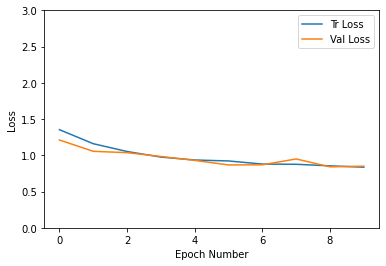

In [15]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

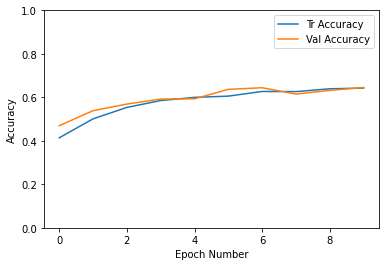

In [16]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()